# Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [ ]:
df = pd.read_csv('Travel.csv')

In [ ]:
num_cols = ['CustomerID','Age','DurationOfPitch','NumberOfTrips','MonthlyIncome']
cat_cols = [col for col in df.columns if col not in num_cols]
df[cat_cols] = df[cat_cols].astype(object)

## Handling Invalid Value

1. There is a typo in the `Gender` column where 'Fe male' should be 'Female'
2. There is a different use of terms for 'Unmarried' and 'Single' where both statuses are the same

In [ ]:
df['Gender'] = df['Gender'].replace({'Fe Male': 'Female'})
df['MaritalStatus'] = df['MaritalStatus'].replace({'Unmarried': 'Single'})

## Handling Missing Value

In [ ]:
missing_values = df.isnull().sum()
print(missing_values)

CustomerID                    0
ProdTaken                     0
Age                         226
TypeofContact                25
CityTier                      0
DurationOfPitch             251
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            45
ProductPitched                0
PreferredPropertyStar        26
MaritalStatus                 0
NumberOfTrips               140
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     66
Designation                   0
MonthlyIncome               233
dtype: int64


We will use mice imputation in handling missing values.

In [ ]:
col_to_impute = ['Age','DurationOfPitch','NumberOfFollowups','PreferredPropertyStar','NumberOfTrips','NumberOfChildrenVisiting','MonthlyIncome']

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(random_state=100, max_iter=10)
df[col_to_impute] = imputer.fit_transform(df[col_to_impute])

In [ ]:
num_cols = ['CustomerID','Age','DurationOfPitch','NumberOfTrips','MonthlyIncome']
df['NumberOfTrips'] = df['NumberOfTrips'].round()
cat_float_cols = [col for col in df.columns if df[col].dtype == np.float64 and col not in num_cols]
for col in cat_float_cols:
  df[col] = df[col].round().astype(object)

In [ ]:
df['TypeofContact'].fillna(df['TypeofContact'].mode()[0], inplace=True)

In [ ]:
df.isnull().sum()

CustomerID                  0
ProdTaken                   0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch             0
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
MaritalStatus               0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
OwnCar                      0
NumberOfChildrenVisiting    0
Designation                 0
MonthlyIncome               0
dtype: int64

After the missing value imputation process was carried out using the MICE method, the dataset had no missing values.

## Handling Duplicated Data

In [ ]:
df.duplicated(subset=['CustomerID']).sum()

0

Based on the checking results above, there are no duplicate values. However, we will also check regardless of the `CustomerID` column, whether there are any duplicate rows.


In [ ]:
# remove CustomerID to see duplicate rows
df.drop('CustomerID', axis=1, inplace=True)
print(f'The number of rows before deleting duplicate data is {df.shape[0]}')

# remove duplicate rows
df.drop_duplicates(inplace=True)
print(f'The number of rows after deleting duplicate data is {df.shape[0]}')

The number of rows before deleting duplicate data is 4888
The number of rows after deleting duplicate data is 4747


We removed 141 duplicate rows regardless of different customer IDs.

## Handling Outlier

Due to the small dataset, we use the Z-Score method to deal with outliers.

In [ ]:
# view total rows before filtered
print(f'The number of rows before filtering outliers is {df.shape[0]}')

# handle outlier using z-score
filtered_entries = np.array([True] * len(df))
skewed_cols = ['DurationOfPitch', 'NumberOfTrips', 'MonthlyIncome']
for col in skewed_cols:
    zscore = abs(stats.zscore(df[col]))
    filtered_entries = (zscore < 3) & filtered_entries

# view total rows after filtered
df = df[filtered_entries]
print(f'The number of rows after filtering outliers is {df.shape[0]}')

The number of rows before filtering outliers is 4747
The number of rows after filtering outliers is 4737


We dropped 10 rows of outliers.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4737 entries, 0 to 4887
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ProdTaken                 4737 non-null   object 
 1   Age                       4737 non-null   float64
 2   TypeofContact             4737 non-null   object 
 3   CityTier                  4737 non-null   object 
 4   DurationOfPitch           4737 non-null   float64
 5   Occupation                4737 non-null   object 
 6   Gender                    4737 non-null   object 
 7   NumberOfPersonVisiting    4737 non-null   object 
 8   NumberOfFollowups         4737 non-null   object 
 9   ProductPitched            4737 non-null   object 
 10  PreferredPropertyStar     4737 non-null   object 
 11  MaritalStatus             4737 non-null   object 
 12  NumberOfTrips             4737 non-null   float64
 13  Passport                  4737 non-null   object 
 14  PitchSat

## Feature Engineering

### Feature Extraction

We will create a new column called `TotalVisiting` by combining the values in the `NumberOfPersonVisiting` and `NumberOfChildrenVisting` columns.

In [ ]:
# Merge column NumberOfPersonVisiting & NumberOfChildrenVisiting

df['TotalVisiting'] = df['NumberOfPersonVisiting'] + df['NumberOfChildrenVisiting']

<ipython-input-219-2338dcced51c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalVisiting'] = df['NumberOfPersonVisiting'] + df['NumberOfChildrenVisiting']


### Feature Transformation ####

Based on the preprocessing data, there are several numerical features that are not normally distributed or have a positive skew. So we do log transformation or standardizing so that the distribution is normal/close to normal.

<Axes: xlabel='MonthlyIncome', ylabel='Density'>

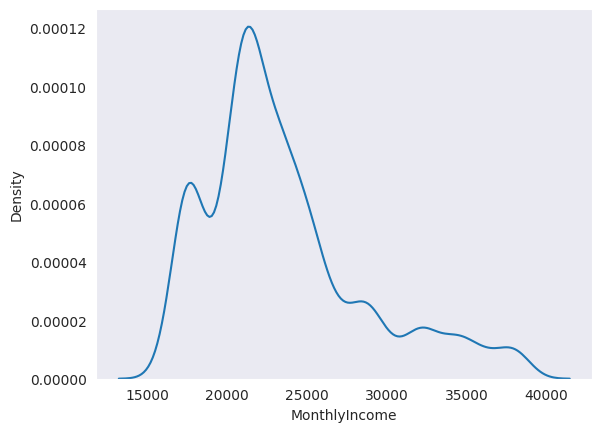

In [ ]:
#MonthlyIncome distribution (original value)
sns.kdeplot(df['MonthlyIncome'])

<Axes: xlabel='log_MonthlyIncome', ylabel='Density'>

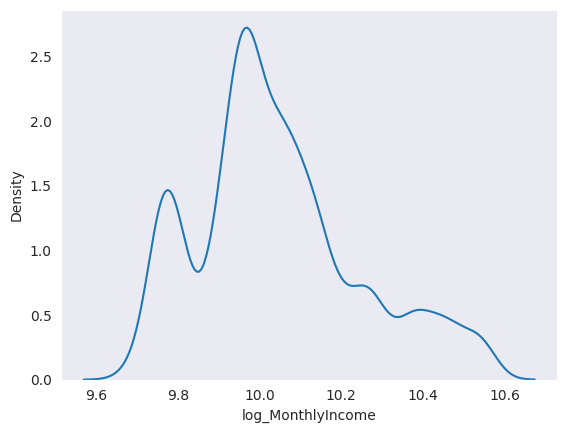

In [ ]:
#MonthlyIncome distribution (After Log Transformation)
df['log_MonthlyIncome']=np.log(df['MonthlyIncome'])
sns.kdeplot(df['log_MonthlyIncome'])

In [ ]:
df= df.drop(columns='MonthlyIncome')

<Axes: xlabel='Age', ylabel='Density'>

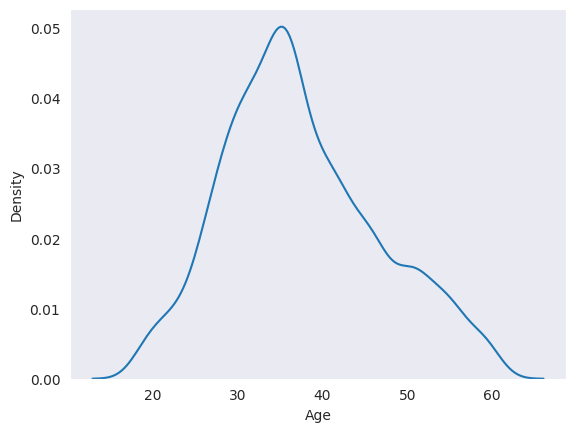

In [ ]:
#Age distribution (original value)
sns.kdeplot(df['Age'])

<Axes: xlabel='stand_Age', ylabel='Density'>

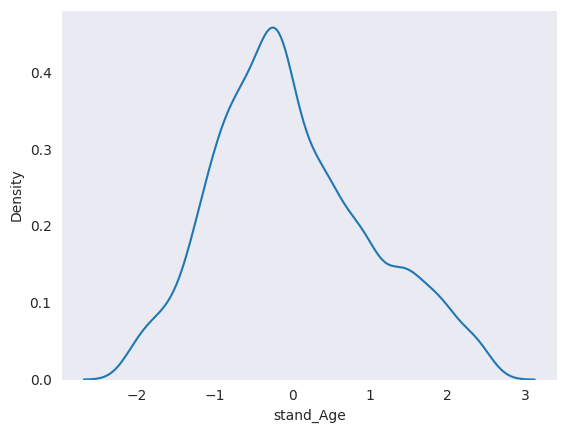

In [ ]:
#Because the distribution is already normal, we only need to standardize it
df['stand_Age']=StandardScaler().fit_transform(df['Age'].values.reshape(len(df), 1))
sns.kdeplot(df['stand_Age'])

In [ ]:
df= df.drop(columns='Age')

<Axes: xlabel='DurationOfPitch', ylabel='Density'>

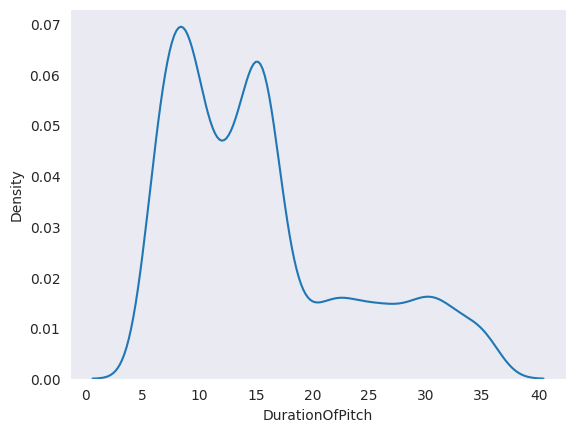

In [ ]:
#DurationOfPitch distribution (original value)
sns.kdeplot(df['DurationOfPitch'])

<Axes: xlabel='log_DurationOfPitch', ylabel='Density'>

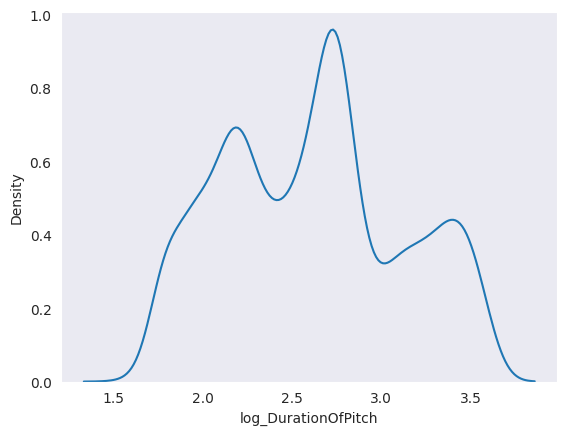

In [ ]:
#DurationOfPitch distribution (After Log Transformation)
df['log_DurationOfPitch']=np.log(df['DurationOfPitch'])
sns.kdeplot(df['log_DurationOfPitch'])

In [ ]:
df= df.drop(columns='DurationOfPitch')

### Feature Encoding

We will use LabelEncoder for ordinal columns and OneHotEncoder for nominal columns.

In [ ]:
cat_cols = df.select_dtypes(include='object').columns.tolist()

In [ ]:
for col in cat_cols:
    print(col)
    print(df[col].value_counts())
    print()

ProdTaken
0    3845
1     892
Name: ProdTaken, dtype: int64

TypeofContact
Self Enquiry       3371
Company Invited    1366
Name: TypeofContact, dtype: int64

CityTier
1    3090
3    1459
2     188
Name: CityTier, dtype: int64

Occupation
Salaried          2287
Small Business    2028
Large Business     420
Free Lancer          2
Name: Occupation, dtype: int64

Gender
Male      2829
Female    1908
Name: Gender, dtype: int64

NumberOfPersonVisiting
3    2331
2    1360
4    1008
1      35
5       3
Name: NumberOfPersonVisiting, dtype: int64

NumberOfFollowups
4.0    2014
3.0    1441
5.0     744
2.0     228
1.0     175
6.0     135
Name: NumberOfFollowups, dtype: int64

ProductPitched
Basic           1794
Deluxe          1680
Standard         714
Super Deluxe     324
King             225
Name: ProductPitched, dtype: int64

PreferredPropertyStar
3.0    2899
5.0     937
4.0     901
Name: PreferredPropertyStar, dtype: int64

MaritalStatus
Married     2277
Single      1512
Divorced     948
Name:

In [ ]:
# Encoding categorical using library LabelEncoder
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df.Occupation=encoder.fit_transform(df.Occupation)
df.Designation=encoder.fit_transform(df.Designation)
df.ProductPitched=encoder.fit_transform(df.ProductPitched)
df.sample(10, random_state=50)

,ProdTaken,TypeofContact,CityTier,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,TotalVisiting,log_MonthlyIncome,stand_Age,log_DurationOfPitch
0,1,Self Enquiry,3,2,Female,3,3.0,1,3.0,Single,1.0,1,2,1,0.0,2,3.0,9.951944,0.384184,1.791759
2956,0,Self Enquiry,1,3,Male,3,5.0,0,3.0,Single,2.0,0,2,0,1.0,1,4.0,9.938999,-1.038116,2.302585
4229,0,Company Invited,1,2,Female,3,4.0,0,3.0,Single,2.0,0,5,0,1.0,1,4.0,9.958591,0.712407,2.833213
4881,1,Self Enquiry,2,2,Male,3,2.0,0,5.0,Married,2.0,0,1,1,2.0,1,5.0,9.955368,0.384184,3.218876
3468,0,Self Enquiry,1,3,Female,3,4.0,4,3.0,Divorced,4.0,0,5,1,1.0,0,4.0,10.487015,1.150038,2.197225
907,0,Self Enquiry,3,3,Male,2,3.0,2,4.0,Divorced,1.0,0,5,1,1.0,4,3.0,10.410697,0.712407,2.397895
2326,0,Self Enquiry,1,2,Male,2,4.0,0,3.0,Single,2.0,0,3,0,0.0,1,2.0,9.799959,-1.913378,1.609438
1034,0,Self Enquiry,1,3,Male,3,5.0,3,5.0,Married,3.0,1,3,0,0.0,3,3.0,10.160105,0.821815,3.258097
4831,1,Self Enquiry,1,2,Female,3,4.0,0,3.0,Single,3.0,1,5,1,1.0,1,4.0,10.052597,-0.272262,3.178054
2102,0,Company Invited,1,3,Male,2,3.0,0,3.0,Single,6.0,1,1,1,1.0,1,3.0,9.770813,0.493592,2.079442


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Creating instance of OneHotEncoder
encoder = OneHotEncoder()

# Define the columns to be one-hot encoded
columns_to_encode = ['Gender', 'TypeofContact', 'MaritalStatus']

# Create the ColumnTransformer
ct = ColumnTransformer([('encoder', encoder, columns_to_encode)], remainder='passthrough')

# Apply one-hot encoding to the selected columns
encoded_data = ct.fit_transform(df)

# Create a new DataFrame with the encoded data
encoded_df = pd.DataFrame(encoded_data)

# Update column names for one-hot encoded columns
encoded_columns = ct.named_transformers_['encoder'].get_feature_names_out(columns_to_encode)
new_columns = list(encoded_columns) + list(df.columns.drop(columns_to_encode))
encoded_df.columns = new_columns

# Update df with the encoded DataFrame
df = encoded_df

# Display the resulting dataset
df

,Gender_Female,Gender_Male,TypeofContact_Company Invited,TypeofContact_Self Enquiry,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,ProdTaken,CityTier,Occupation,...,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,TotalVisiting,log_MonthlyIncome,stand_Age,log_DurationOfPitch
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1,3,2,...,1.0,1,2,1,0.0,2,3.0,9.951944,0.384184,1.791759
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0,1,2,...,2.0,0,3,1,2.0,2,5.0,9.909967,1.259446,2.639057
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0,...,7.0,1,3,0,0.0,1,3.0,9.746249,-0.053447,2.079442
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,1,2,...,2.0,1,5,1,1.0,1,3.0,9.793059,-0.491078,2.197225
4,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0,1,3,...,1.0,0,5,1,0.0,1,2.0,9.823795,-0.471429,2.079442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4732,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,3,3,...,2.0,1,1,1,1.0,2,4.0,10.187764,1.259446,2.197225
4733,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1,1,2,...,3.0,1,3,1,2.0,1,6.0,9.962322,-1.038116,3.433987
4734,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1,3,2,...,7.0,0,1,1,3.0,3,7.0,10.36785,1.587669,2.833213
4735,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,3,3,...,3.0,0,5,0,2.0,1,5.0,9.917834,-2.022786,2.772589


In [ ]:
df.isnull().sum()

Gender_Female                    0
Gender_Male                      0
TypeofContact_Company Invited    0
TypeofContact_Self Enquiry       0
MaritalStatus_Divorced           0
MaritalStatus_Married            0
MaritalStatus_Single             0
ProdTaken                        0
CityTier                         0
Occupation                       0
NumberOfPersonVisiting           0
NumberOfFollowups                0
ProductPitched                   0
PreferredPropertyStar            0
NumberOfTrips                    0
Passport                         0
PitchSatisfactionScore           0
OwnCar                           0
NumberOfChildrenVisiting         0
Designation                      0
TotalVisiting                    0
log_MonthlyIncome                0
stand_Age                        0
log_DurationOfPitch              0
dtype: int64

### Feature Selection ###

#### Option 1: ANOVA ####

In [ ]:
df=df.astype(np.float64)

In [ ]:
# separate feature and target
X = df.drop(['ProdTaken'], axis=1, inplace=False)
y = df['ProdTaken'].values

In [ ]:
# import library
from sklearn.feature_selection import f_regression, SelectKBest

# Applying SelectKBest class to extract top 10 best features
fs = SelectKBest(score_func=f_regression,k=10)
# Applying feature selection
fit = fs.fit(X,y)

In [ ]:
features_score = pd.DataFrame(fit.scores_)
features = pd.DataFrame(X.columns)
feature_score = pd.concat([features,features_score],axis=1)
# Assigning column names
feature_score.columns = ["Input_Features","F_Score"]
print(feature_score.nlargest(15,columns="F_Score"))

                   Input_Features     F_Score
14                       Passport  349.887262
6            MaritalStatus_Single  189.338584
11                 ProductPitched  131.313478
21                      stand_Age   99.316231
20              log_MonthlyIncome   91.005589
5           MaritalStatus_Married   73.987553
10              NumberOfFollowups   62.200693
12          PreferredPropertyStar   44.936509
18                    Designation   43.418107
7                        CityTier   36.756101
22            log_DurationOfPitch   32.227653
4          MaritalStatus_Divorced   25.768527
15         PitchSatisfactionScore   12.767022
2   TypeofContact_Company Invited    8.149897
3      TypeofContact_Self Enquiry    8.149897


The F_Score results from the ANOVA method show that there are no features that are too dominant so they are relatively distributed.

#### Option 2 : Random Forest Feature Performance

In [ ]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

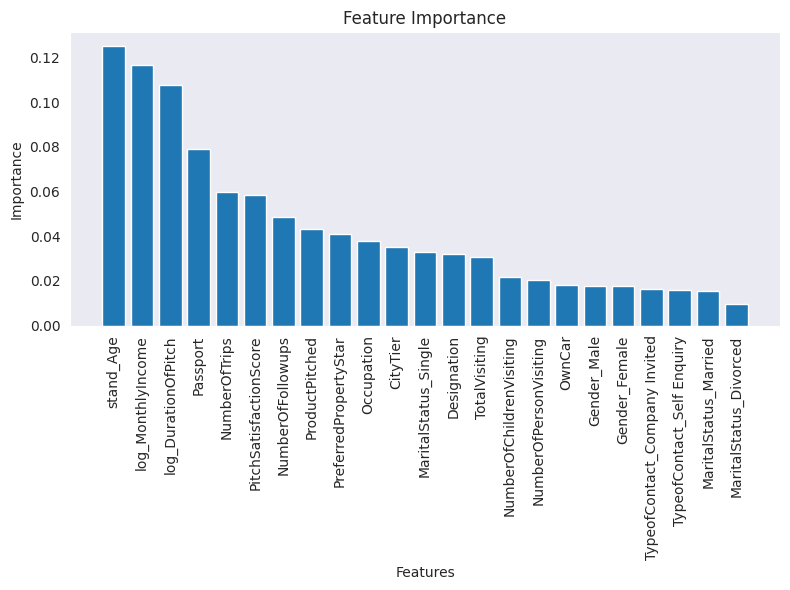

In [ ]:
# Train Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X, y)

# Extract feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = feature_names[indices]

# Plot feature importances as a histogram
plt.figure(figsize=(8, 6))
plt.bar(sorted_feature_names, sorted_importances)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

The Feature Performance results from the Random Forest method show that there are no features that are too dominant so that they are relatively distributed.

## Declaring features and target variable

* Target: `ProdTaken` column
* Features: All columns except `ProdTaken`, `DurationOfPitch`, `NumberOfFollowups`, `ProductPitched`, and `PitchSatisfactionScore` columns

In [ ]:
# separate feature and target
X = df.drop(['ProdTaken','log_DurationOfPitch','NumberOfFollowups','ProductPitched','PitchSatisfactionScore'], axis=1, inplace=False)
y = df['ProdTaken'].values

## Split the data into train & test set with 70:30 ratio

In [ ]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=32, stratify=y)

In [ ]:
# check the shape of X_train and X_test

print(f'The training dataset consists of {len(X_train)} rows')
print(f'The test dataset consists of {len(X_test)} rows')

The training dataset consists of 3315 rows
The test dataset consists of 1422 rows


## Handling Imbalance

*Oversampling* needs to be done because there is an imbalance in the target column. Oversampling will be done using the SMOTE method.

In [ ]:
from imblearn import under_sampling, over_sampling
X_over_SMOTE, y_over_SMOTE = over_sampling.SMOTE(random_state=32).fit_resample(X_train, y_train)
print(X_over_SMOTE.shape)
print(y_over_SMOTE.shape)

(5382, 19)
(5382,)


In [ ]:
print('Original')
print(pd.Series(y_train).value_counts())
print('\n')
print('SMOTE')
print(pd.Series(y_over_SMOTE).value_counts())

Original
0.0    2691
1.0     624
dtype: int64


SMOTE
0.0    2691
1.0    2691
dtype: int64


In [ ]:
X_train = X_over_SMOTE
y_train = y_over_SMOTE

After oversampling using SMOTE, it can be seen that the amount of data on the target has been distributed evenly, therefore it is ready for modeling.

# Modelling

At the modeling stage, we will compare several methods and later we will choose which model produces the best performance. The model with the best performance that we will choose in a later stage.

In [ ]:
# import libraries for modelling
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## Define Classifiers

In [ ]:
# Model assignment
rfc = RandomForestClassifier(random_state=14)
etc = ExtraTreesClassifier(random_state=14)
gbc = GradientBoostingClassifier(random_state=14)
bgc = BaggingClassifier(random_state=14)
xgb = XGBClassifier(eval_metric='error',random_state=14)

models = [rfc, etc, gbc, bgc, xgb]

model_name = []

# Get Classifier names for every model
for name in models:
    names = str(type(name)).split('.')[-1][:-2]
    # Append classifier names to model_name list
    model_name.append(names)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV, cross_val_score, RandomizedSearchCV

## Cross Validation

At this stage, we do training on all data using cross-validation. This is done to predict the best model results and will be used.

In [ ]:
# Cross validation for each model
rfc_score = cross_val_score(models[0], X, y, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
etc_score = cross_val_score(models[1], X, y, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
gbc_score = cross_val_score(models[2], X, y, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
bgc_score = cross_val_score(models[3], X, y, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
xgb_score = cross_val_score(models[4], X, y, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


In [ ]:
# List of score per model
cv_result = [rfc_score, etc_score, gbc_score, bgc_score, xgb_score]

# Create dataframe for score every k-fold
df_cv_result = pd.DataFrame(cv_result, index=model_name)
df_cv_result

,0,1,2,3,4
RandomForestClassifier,0.902954,0.900844,0.893347,0.881732,0.908131
ExtraTreesClassifier,0.909283,0.905063,0.901795,0.900739,0.927138
GradientBoostingClassifier,0.863924,0.864979,0.864836,0.848997,0.876452
BaggingClassifier,0.932489,0.901899,0.903907,0.894403,0.919747
XGBClassifier,0.917722,0.912447,0.917635,0.901795,0.929250


Index 0 - 4 above is the number of trials performed. In this case, we use k-fold with k = 5 which means doing 5 attempts to test the dataset. This is done in order to be able to predict the best model performance results to use. From these results, it can be seen that the `XGBClassifier` has relatively stable performance at a value of 0.90-0.92 in each trial so the possibility to use XGBClassifier is even greater. However, the results of the 5 experiments above will be calculated based on the average of each model so that later the model with the best performance will be used.

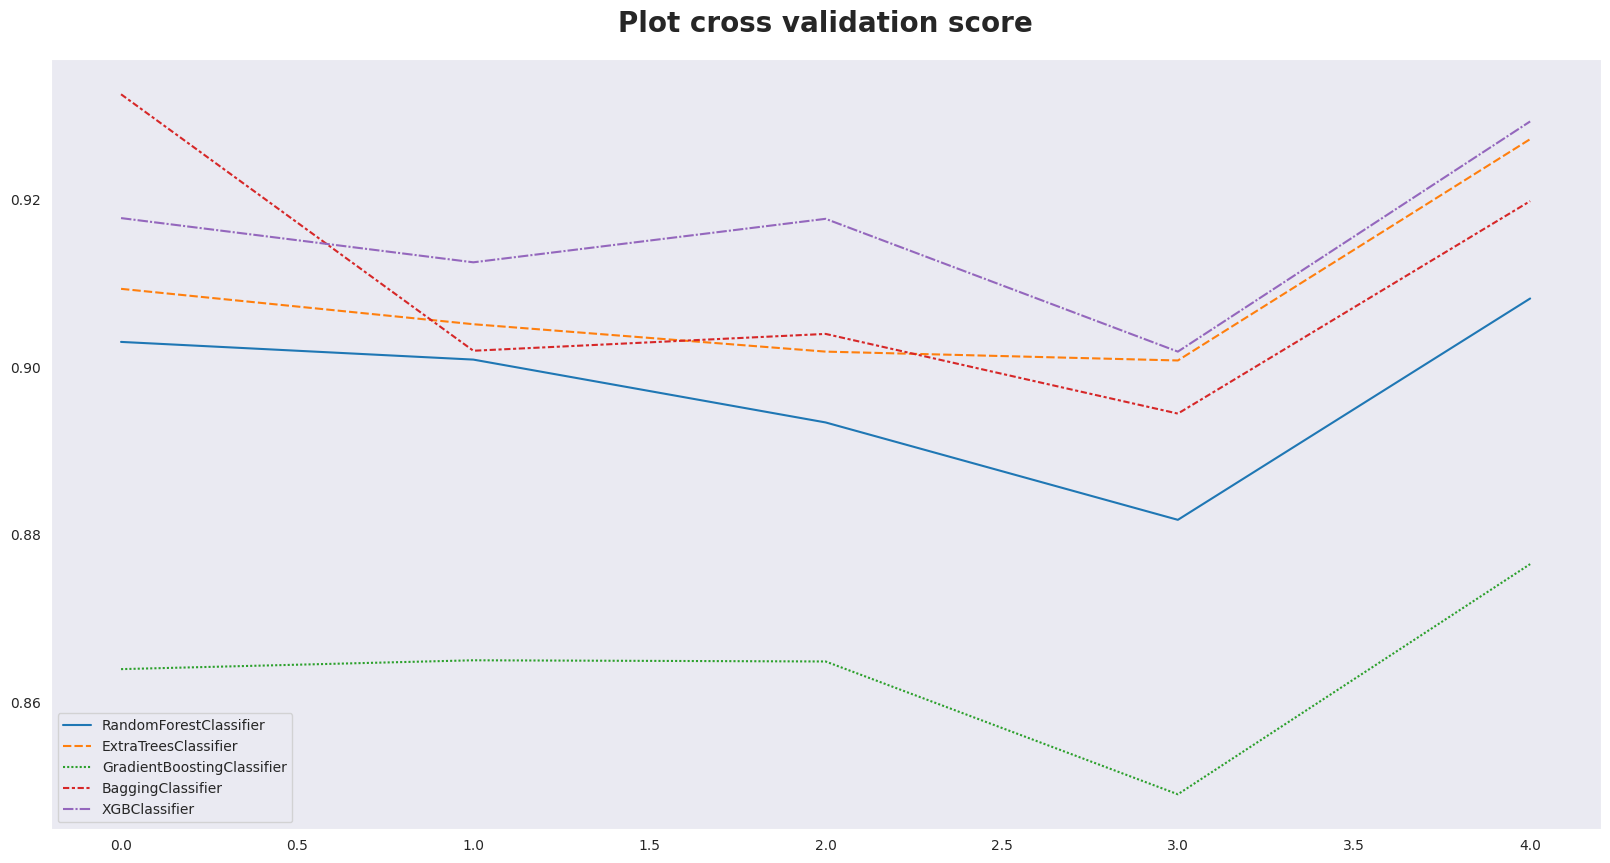

In [ ]:
# Plot cross validation score
sns.set_style('dark')
plt.figure(figsize=(20,10))
plt.title('Plot cross validation score',fontsize=20, fontweight='bold', pad=20)
sns.lineplot(data=df_cv_result.T)
plt.show()

In [ ]:
# Calculate average for every k-fold validation
cv_mean = []
i = 0
for mean in cv_result:
    mean = cv_result[i].mean()
    cv_mean.append(mean)
    i += 1

In [ ]:
# Calculate standard deviation for every k-fold validation
cv_std = []
i = 0
for std in cv_result:
    std = cv_result[i].std()
    cv_std.append(std)
    i += 1

In [ ]:
# Average and standard deviation score for each model
df_cv = pd.DataFrame({'score_mean':cv_mean, 'score_std':cv_std}, index=model_name).sort_values(['score_mean', 'score_std'], ascending=[False, True])
df_cv

,score_mean,score_std
XGBClassifier,0.915770,0.008892
BaggingClassifier,0.910489,0.013752
ExtraTreesClassifier,0.908804,0.009639
RandomForestClassifier,0.897402,0.009163
GradientBoostingClassifier,0.863838,0.008737


In the experiment above, the average accuracy value and standard deviation of each model were obtained. Based on these results, XGBClassifier has the best performance with an average accuracy of 0.915770 with a standard deviation of 0.008892

## Fit and Evaluation

Apart from using Cross Validation, we will fit and transform the models on the training and test datasets with the aim of seeing the model scores when the data is trained and tested and see the difference.



In [ ]:
# Create a list to assign a model score
train_score = []
test_score = []

# Create dataframe
df_train_test = pd.DataFrame()
for i in models:
    # Fit each model
    model = i.fit(X_train, y_train)
    # accuracy for training set
    train_score.append(model.score(X_train, y_train))
    # accuracy for testing set
    test_score.append(model.score(X_test, y_test))

In [ ]:
# Create a dataframe to store accuracy score
df_avg_score = pd.DataFrame({
    'train score':train_score,
    'test score':test_score},
    index=model_name)

# Create a new column for the difference in accuracy score
df_avg_score['difference'] = abs(df_avg_score['train score'] - df_avg_score['test score'])
# Sort accuracy by smallest difference
df_avg_score = df_avg_score.sort_values(['train score', 'test score','difference'], ascending=[False, False, True])
df_avg_score

,train score,test score,difference
RandomForestClassifier,1.000000,0.871308,0.128692
ExtraTreesClassifier,1.000000,0.870605,0.129395
XGBClassifier,0.997585,0.863572,0.134012
BaggingClassifier,0.996656,0.859353,0.137302
GradientBoostingClassifier,0.909513,0.832630,0.076883


It can be seen that `XGBClassifier` has a different accuracy value of 13% so it is possible that `XGBClassifier` can be used to get good performance.

Next, we will test the precision, recall, f1-score, and roc-auc-score values on the training and testing data.

In [ ]:
# Calculate accuracy, precision, recall, f1-score, and roc-auc-score
def eval(model,X_train,X_test,y_train,y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    train_score = round((model.score(X_train, y_train) * 100), 2)
    test_score = round((model.score(X_test, y_test) * 100), 2)
    prec_score = round((precision_score(y_test, y_pred)) * 100, 2)
    rec_score = round((recall_score(y_test, y_pred)) * 100, 2)
    f1 = round(f1_score(y_test, y_pred)*100, 2)
    train_roc_auc = round((roc_auc_score(y_train, y_pred_proba_train[:, 1]) * 100), 2)
    test_roc_auc = round((roc_auc_score(y_test, y_pred_proba[:, 1]) * 100), 2)

    return (train_score,test_score,prec_score,rec_score,f1,train_roc_auc,test_roc_auc)

A=[]
for i in models:
    A.append(eval(i,X_train,X_test,y_train,y_test))

In [ ]:
model_eval = pd.DataFrame(A,index=model_name)
model_eval = model_eval.rename(columns={0: 'Training Accuracy', 1: 'Test Accuracy', 2:'Precision Score', 3:'Recall Score', 4:'F1 Score', 5:'ROC_AUC (train-proba)', 6:'ROC_AUC (test-proba)'})
model_eval = model_eval.sort_values(['Recall Score'], ascending=[False])
model_eval = model_eval.reset_index()
model_eval = model_eval.rename(columns={'index': 'Model'})
model_eval


,Model,Training Accuracy,Test Accuracy,Precision Score,Recall Score,F1 Score,ROC_AUC (train-proba),ROC_AUC (test-proba)
0,XGBClassifier,99.76,86.36,68.69,50.75,58.37,100.00,85.72
1,BaggingClassifier,99.67,85.94,67.53,48.88,56.71,99.99,86.05
2,RandomForestClassifier,100.00,87.13,75.15,47.39,58.12,100.00,86.76
3,ExtraTreesClassifier,100.00,87.06,75.00,47.01,57.80,100.00,87.49
4,GradientBoostingClassifier,90.95,83.26,57.08,45.15,50.42,96.79,79.12


In this case, in addition to the accuracy value we calculate, we will also consider the precision value because we prefer our model to have the greatest possible accuracy in predicting potential customers. The Total Positive (TP) in this case is the total customer who is predicted to buy the package and actually buys the package, while the False Positive (FP) in this case is the customer who is predicted to buy the package, but doesn't actually buy the package. Since the number of potential customers is the total number of customers who are predicted to buy, namely TP+FP, and the customers who are predicted to buy and actually buy are TP, the value of TP/(TP+FP) or the precision value is chosen as the best evaluation indicator for the model. It can be seen that the Random Forest and Extra Trees models have the highest precision values. However, because the accuracy value reached 100% and there were indications of overfitting, we chose the XG Boost model as the model that had the best evaluation results. The recall value of the XG Boost model also supports our choice as we either don't want to ignore customers who were not predicted to buy when they actually buy or in other words, we want to get as few False Negative (FN) cases as possible.

## Using XGB Classifier

Next, we will compare the performance of the model before and after hyperparameter tuning.

### Default Parameter

In [ ]:
# Fit classifier
xgb.fit(X_train, y_train)

# predict test set
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)
y_pred_proba_train = xgb.predict_proba(X_train)

# Calculate accuracy, precision, recall, and f1-score
train_score = round((xgb.score(X_train, y_train) * 100), 2)
test_score = round((xgb.score(X_test, y_test) * 100), 2)
prec_score = round((precision_score(y_test, y_pred)) * 100, 2)
rec_score = round((recall_score(y_test, y_pred)) * 100, 2)
f1 = round(f1_score(y_test, y_pred)*100, 2)
train_roc_auc = round((roc_auc_score(y_train, y_pred_proba_train[:, 1]) * 100), 2)
test_roc_auc = round((roc_auc_score(y_test, y_pred_proba[:, 1]) * 100), 2)

print('Training Accuracy : {}%'.format(train_score))
print('Test Accuracy : {}%'.format(test_score))
print('Precision Score : {}%'.format(prec_score))
print('Recall Score : {}%'.format(rec_score))
print('F1 Score : {}%'.format(f1))
print('roc_auc (train-proba) : {}%'.format(train_roc_auc))
print('roc_auc (test-proba) : {}%'.format(test_roc_auc))

Training Accuracy : 99.76%
Test Accuracy : 86.36%
Precision Score : 68.69%
Recall Score : 50.75%
F1 Score : 58.37%
roc_auc (train-proba) : 100.0%
roc_auc (test-proba) : 85.72%


In [ ]:
pd.DataFrame({
    'train_acc':[train_score],
    'test_acc':[test_score],
    'precision':[prec_score],
    'recall':[rec_score],
    'f1-score':[f1],
    'roc_auc (train-proba)':[train_roc_auc],
    'roc_auc (test-proba)':[test_roc_auc]}, index=['Default XGB'])

,train_acc,test_acc,precision,recall,f1-score,roc_auc (train-proba),roc_auc (test-proba)
Default XGB,99.76,86.36,68.69,50.75,58.37,100.0,85.72


### Hyperparameter Tuning

In [ ]:
params = {
    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
    'tree_method' : ['auto', 'exact', 'approx', 'hist'],

    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
    #'n_estimators': [10, 20, 50, 100, 200, 500, 1000, 1200, 1500, 1800, 1900, 2000, 2100, 3000],
    #'criterion': ['gini', 'entropy'],
    #'max_depth': [1, 2, 5, 8, 13, 21, 34, 53, 54, 55, 89, None]
}

xgb_tuned = RandomizedSearchCV(
    estimator=XGBClassifier(),
    param_distributions=params,
    n_iter=10,
    scoring='recall',
    cv=5,
    n_jobs=-1)

In [ ]:
xgb_tuned.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'gamma': [0.0, 0.1, 0.2,
                                                  0.30000000000000004, 0.4, 0.5,
                                                  0.6000000000000001,
                                                  0.7000000000000001, 0.8, 0.9,
                                                  1.0],
                                        'lambda': [0.0, 0.1, 0.2,
                                                   0.30000000000000004, 0.4,
                                                   0.5, 0.6000000000000001,
                                                   0.7000000000000001, 0.8, 0.9,
                                                   1.0],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'min_child_weight': [1, 2, 4, 6, 8, 10,
                                                             12, 14, 16, 18,
                                                             20],
                                        'tree_method': ['auto', 'exact',
                                                        'approx', 'hist']},
                   scoring='recall')

In [ ]:
# best estimator for xgboost
xgb_tuned.best_estimator_

XGBClassifier(alpha=0.5, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eta=0.7070707070707072,
              eval_metric=None, feature_types=None, gamma=0.4, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.6000000000000001,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=20,
              max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None, ...)

In [ ]:
# Predict test set
y_pred_tuned = xgb_tuned.predict(X_test)
y_pred_proba_tuned = xgb.predict_proba(X_test)
y_pred_proba_train_tuned = xgb.predict_proba(X_train)

#Calculate accuracy, precision, recall, and f1-score
train_score_tuned = round((xgb_tuned.score(X_train, y_train) * 100), 2)
test_score_tuned = round((xgb_tuned.score(X_test, y_test) * 100), 2)
prec_score_tuned = round((precision_score(y_test, y_pred_tuned)) * 100, 2)
rec_score_tuned = round((recall_score(y_test, y_pred_tuned)) * 100, 2)
f1_tuned = round(f1_score(y_test, y_pred_tuned)*100, 2)
train_roc_auc_tuned = round((roc_auc_score(y_train, y_pred_proba_train_tuned[:, 1]) * 100), 2)
test_roc_auc_tuned = round((roc_auc_score(y_test, y_pred_proba_tuned[:, 1]) * 100), 2)

print('Training Accuracy : {}%'.format(train_score_tuned))
print('Test Accuracy : {}%'.format(test_score_tuned))
print('Precision Score : {}%'.format(prec_score_tuned))
print('Recall Score : {}%'.format(rec_score_tuned))
print('F1 Score : {}%'.format(f1_tuned))
print('roc_auc (train-proba) : {}%'.format(train_roc_auc_tuned))
print('roc_auc (test-proba) : {}%'.format(test_roc_auc_tuned))

Training Accuracy : 99.93%
Test Accuracy : 47.01%
Precision Score : 67.02%
Recall Score : 47.01%
F1 Score : 55.26%
roc_auc (train-proba) : 100.0%
roc_auc (test-proba) : 85.72%


In [ ]:
pd.DataFrame({
    'train_acc':[train_score, train_score_tuned],
    'test_acc':[test_score, test_score_tuned],
    'precision':[prec_score, prec_score_tuned],
    'recall':[rec_score, rec_score_tuned],
    'f1-score':[f1, f1_tuned],
    'roc_auc (train-proba)':[train_roc_auc, train_roc_auc_tuned],
    'roc_auc (test-proba)':[test_roc_auc, test_roc_auc_tuned]}, index=['xgb', 'xgb_tuned'])

,train_acc,test_acc,precision,recall,f1-score,roc_auc (train-proba),roc_auc (test-proba)
xgb,99.76,86.36,68.69,50.75,58.37,100.0,85.72
xgb_tuned,99.93,47.01,67.02,47.01,55.26,100.0,85.72


After doing hyperparameter tuning, it turned out that the model experienced a decrease in the accuracy value of the test data and further enlarged the difference in the accuracy values of the training data and test data so that there was an indication of overfitting. Because the overall model has experienced a decrease in performance, we will use the default parameters.

## Model Evaluation

### Confusion Matrix

[[1092   62]
 [ 132  136]]


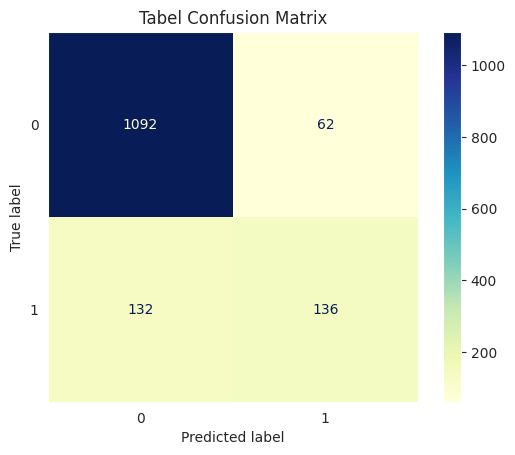

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='YlGnBu')
plt.title('Tabel Confusion Matrix')
plt.show()

In [ ]:
# Classification report model
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92      1154
         1.0       0.69      0.51      0.58       268

    accuracy                           0.86      1422
   macro avg       0.79      0.73      0.75      1422
weighted avg       0.85      0.86      0.86      1422



In [ ]:
# Precision Recall Curve
y_pred = xgb.predict_proba(X_test)[:,1]
prec, recall, _ = precision_recall_curve(y_test, y_pred, pos_label=xgb.classes_[1])
pr_display = PrecisionRecallDisplay(prec, recall)

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=xgb.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

ROC AUC Score is : 0.8572195349077836


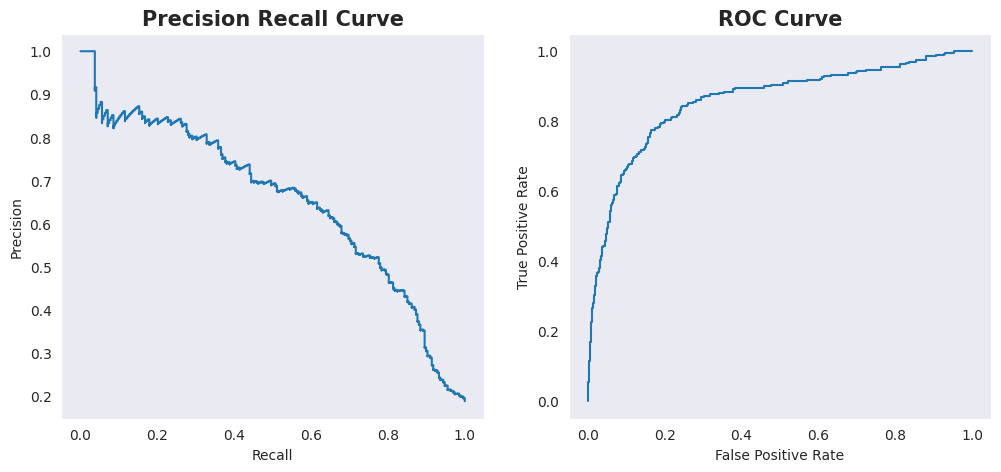

In [ ]:
# roc auc score
auc_score = roc_auc_score(y_test, y_pred)
print(f'ROC AUC Score is : {auc_score}')

# Plotting Precision Recall and ROC Curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

pr_display.plot(ax=ax1)
roc_display.plot(ax=ax2)
ax1.set_title('Precision Recall Curve', fontsize=15, fontweight='bold')
ax2.set_title('ROC Curve', fontsize=15, fontweight='bold')
plt.show()

## Feature Importance

In [ ]:
feature_importance = pd.DataFrame({
    'Features':X.columns,
    'Importance':xgb.feature_importances_}).sort_values('Importance', ascending=False)

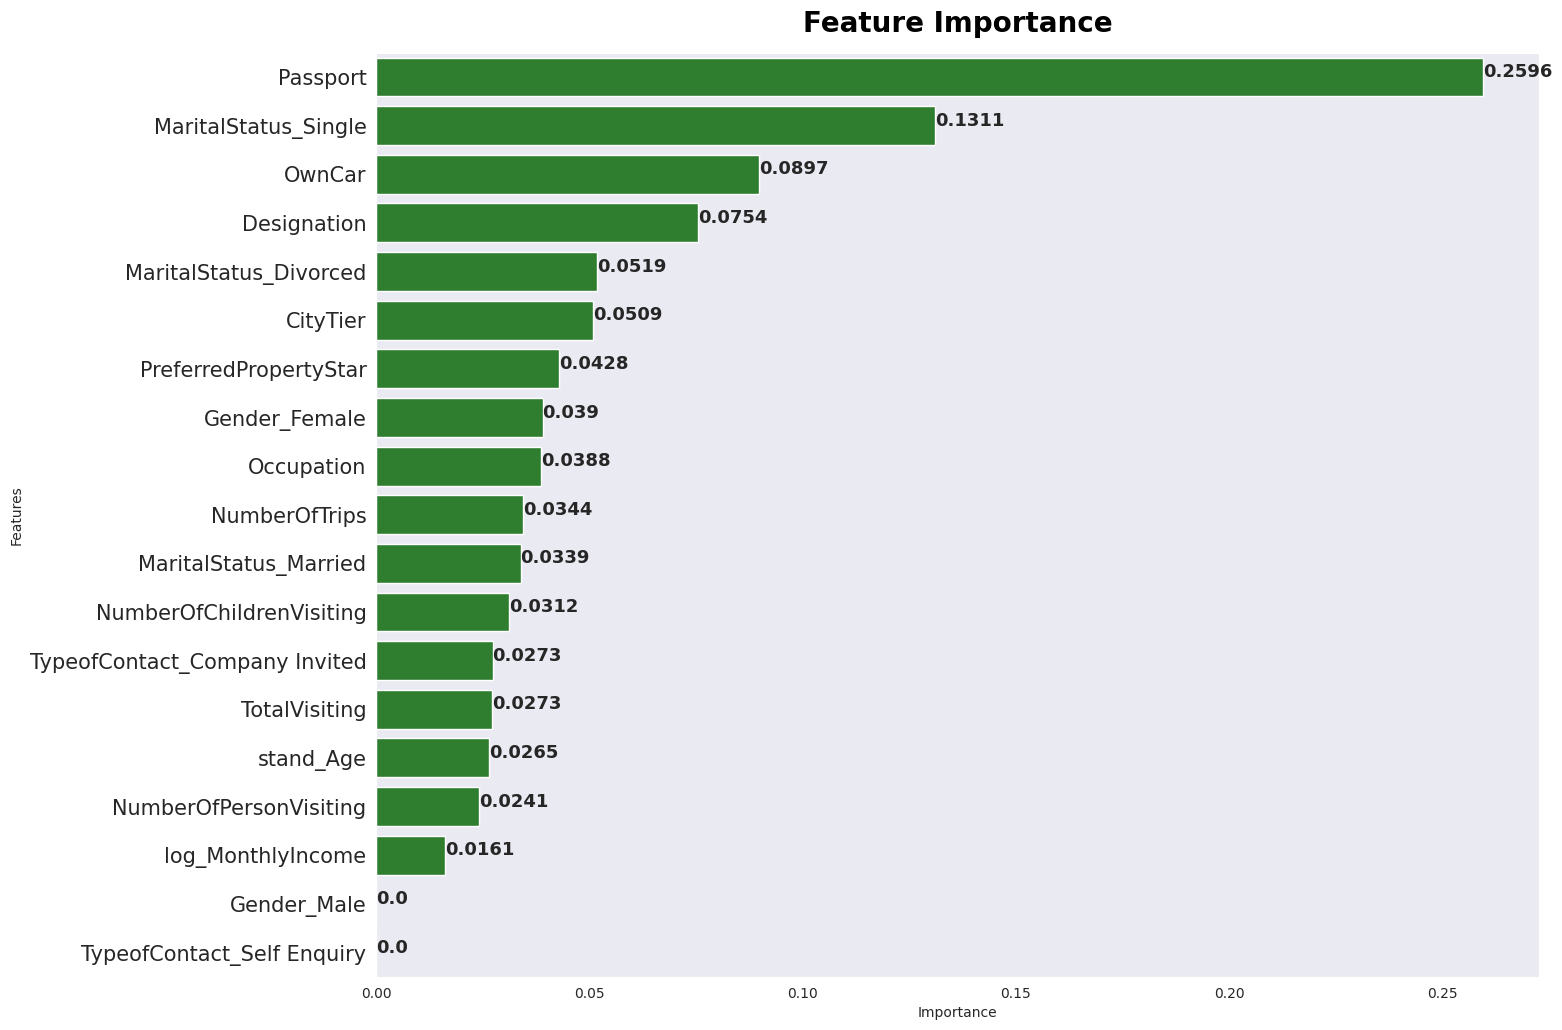

In [ ]:
plt.figure(figsize=(15, 12))
sns.barplot(data=feature_importance, x='Importance', y='Features', color='forestgreen')

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i],i, round(x[i], 4), fontsize=13, fontweight='bold')

x = list(feature_importance['Importance'])
y = list(feature_importance['Features'])

plt.title('Feature Importance', fontsize=20, color='black', pad=15, fontweight='bold')
plt.yticks(fontsize=15)
addlabels(x, y)
plt.show()

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.1/547.1 kB 8.8 MB/s eta 0:00:00


In [ ]:
from xgboost import XGBClassifier
dt = XGBClassifier()
dt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


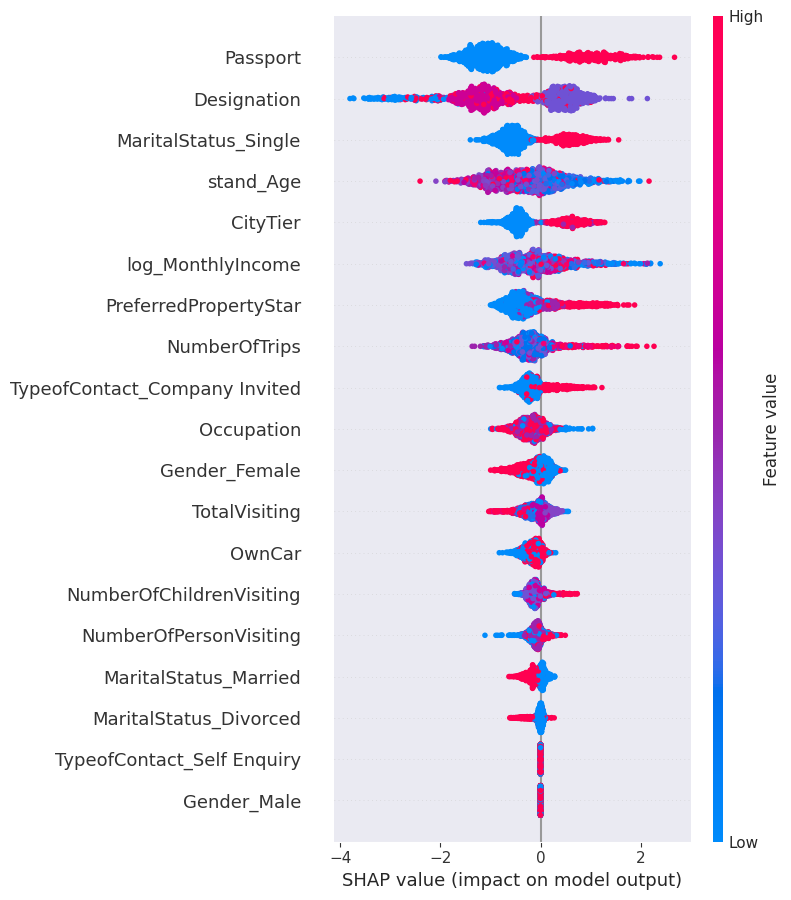

In [ ]:
import shap
explainer = shap.TreeExplainer(dt)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)